In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from keras import models
from keras import layers
import tensorflow as tf
from tensorflow.keras import optimizers
import pickle

In [2]:
df=pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.shape

(1338, 7)

In [4]:
print("Unique values of sex field",df['sex'].unique())
print("Unique values of smoker field",df['smoker'].unique())
print("Unique values of region fieldr",df['region'].unique())

Unique values of sex field ['female' 'male']
Unique values of smoker field ['yes' 'no']
Unique values of region fieldr ['southwest' 'southeast' 'northwest' 'northeast']


In [5]:
#checking missing values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
#details of the dataset
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
#encoding categorical variables
final_data=pd.get_dummies(df,drop_first=True)
final_data.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


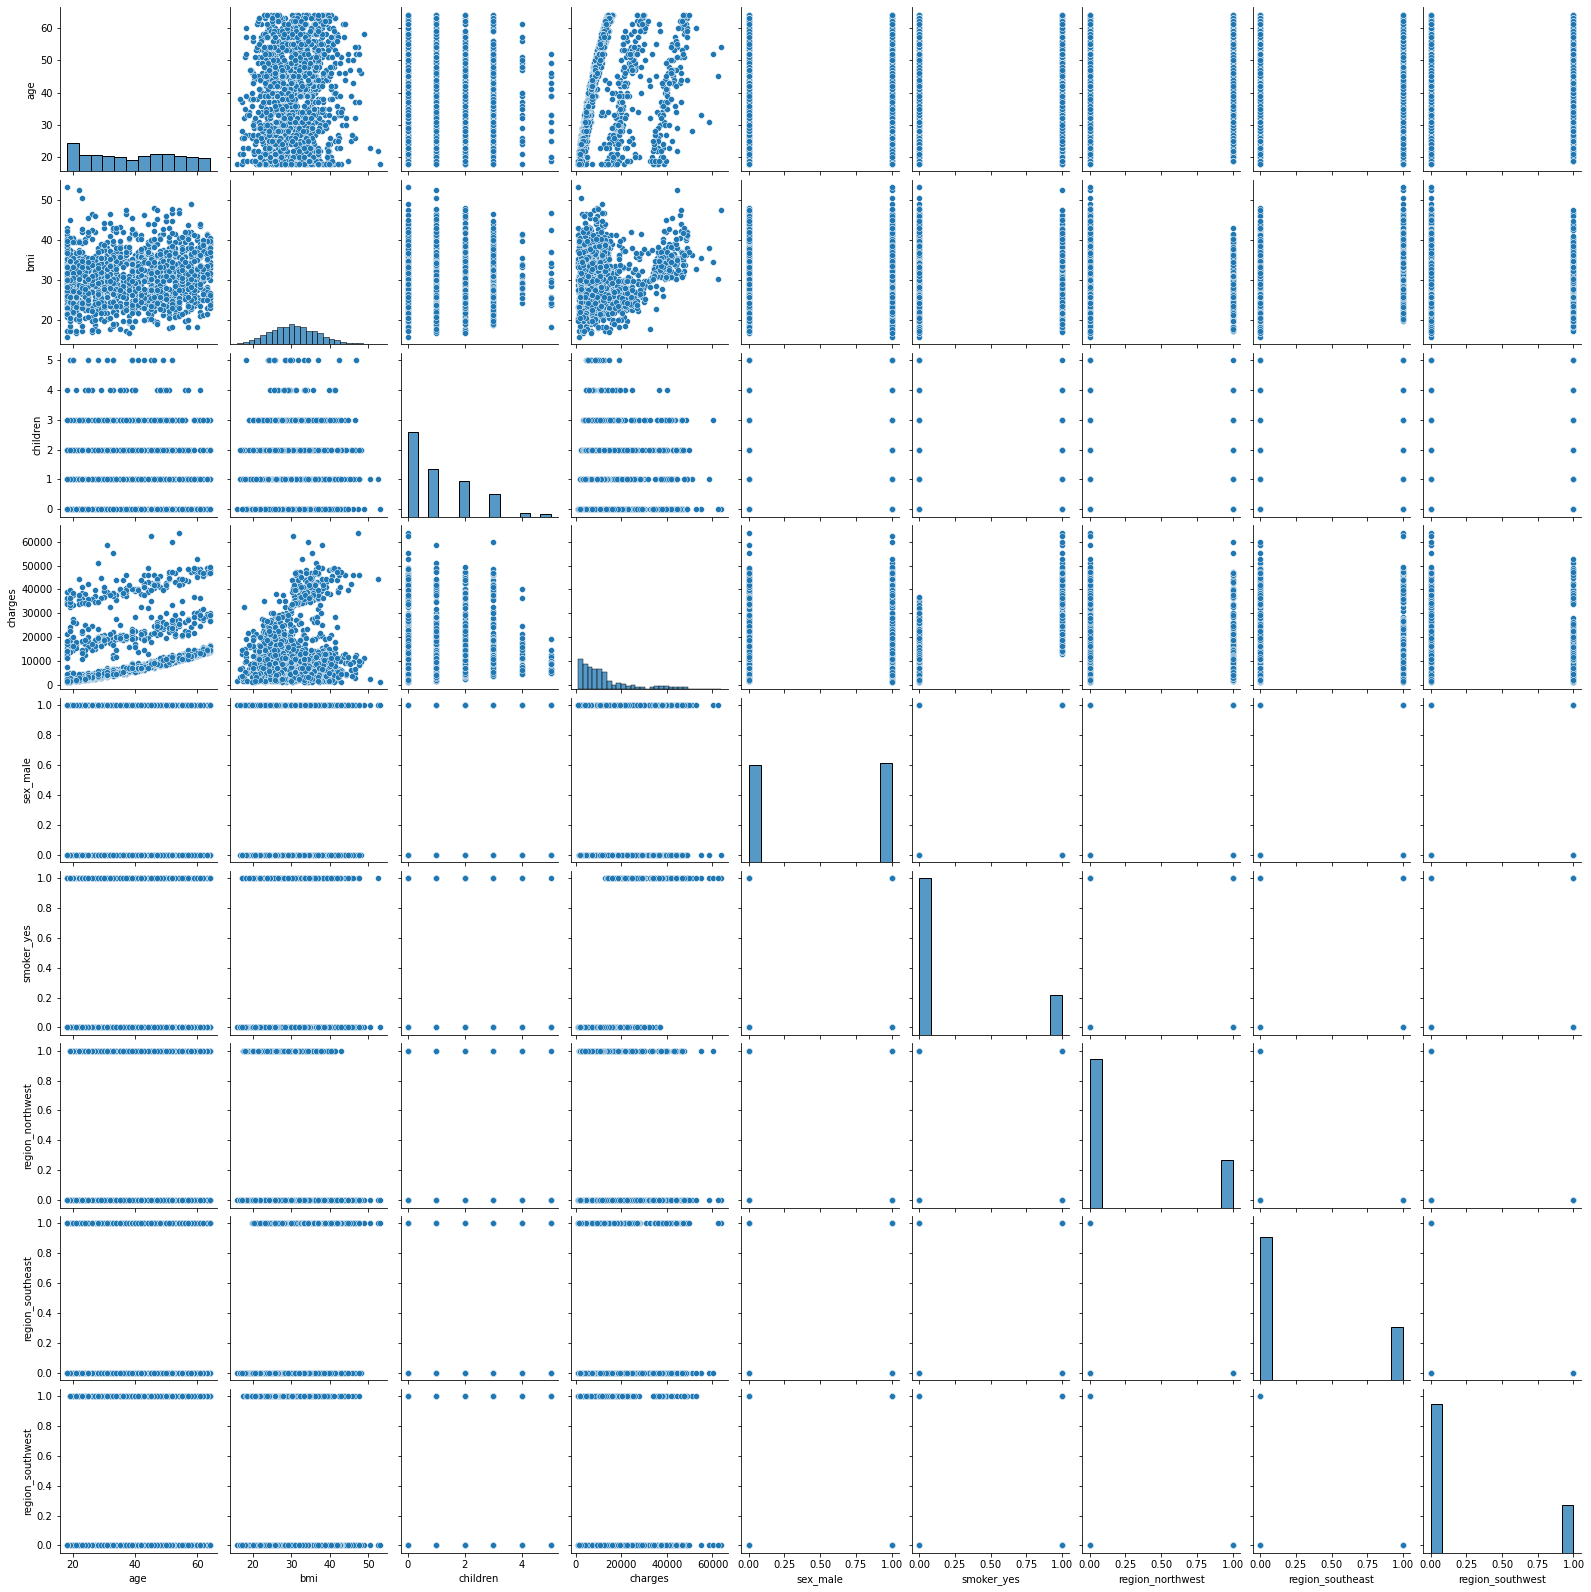

In [8]:
sns.pairplot(final_data)

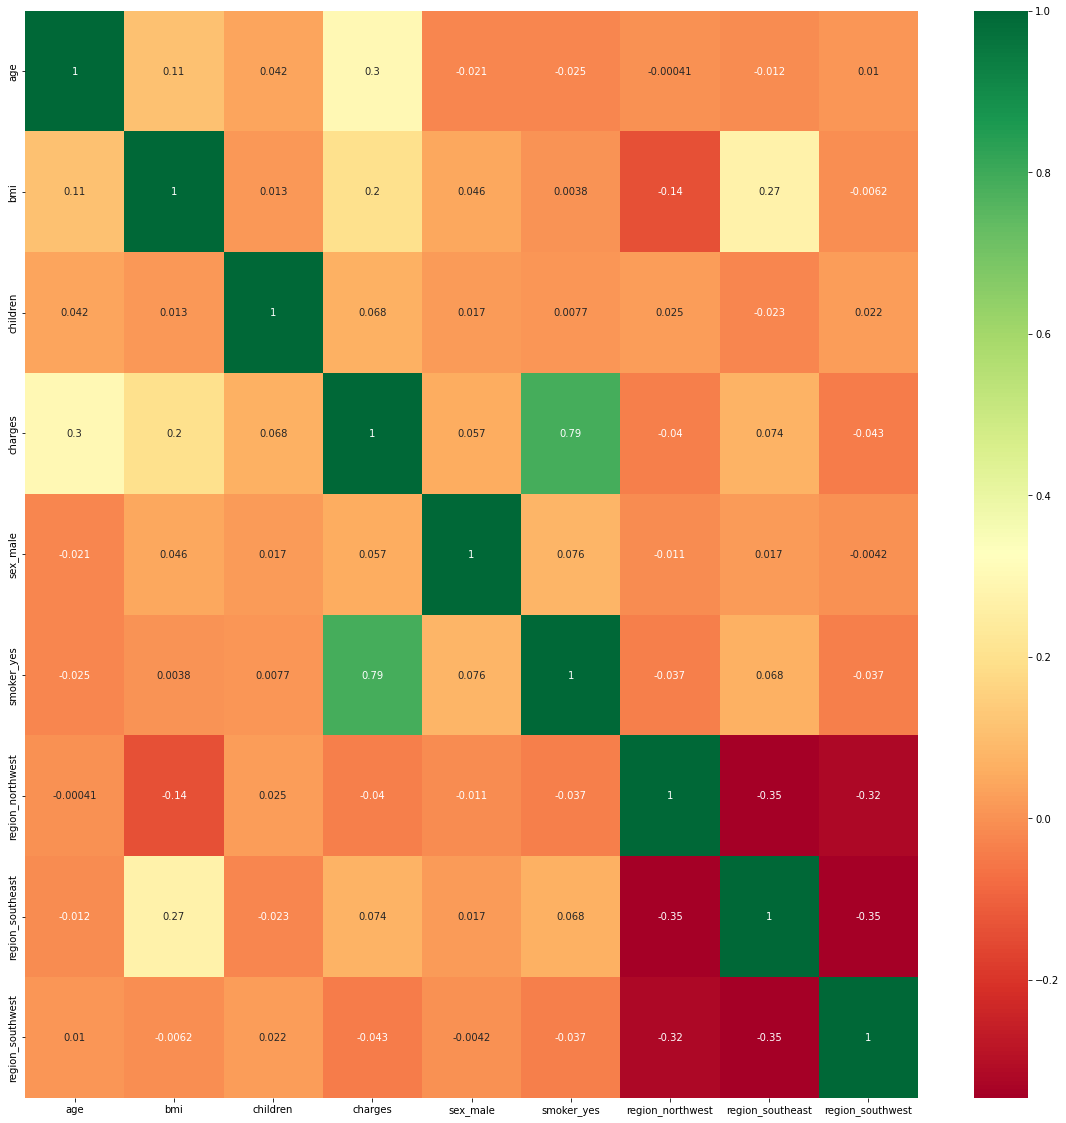

In [9]:
corr_mat = final_data.corr()
top_corr_features = corr_mat.index
plt.figure(figsize=(20,20))
corr_heatmap = sns.heatmap(final_data[top_corr_features].corr(), annot=True,cmap="RdYlGn")

In [10]:
X=final_data.loc[:, final_data.columns != 'charges']
y=final_data.iloc[:,3]

Feature importance:  [0.12973609 0.19057786 0.02420176 0.01047314 0.62059197 0.00951312
 0.00873383 0.00617223]


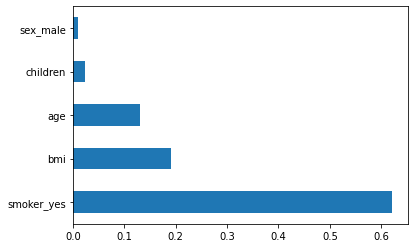

In [11]:
#feature importance
model=ExtraTreesRegressor()
model.fit(X,y)
print("Feature importance: ",model.feature_importances_)
#plot to see 5 important features
f_i = pd.Series(model.feature_importances_, index=X.columns)
f_i.nlargest(5).plot(kind='barh')
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2)

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Model 1: Elastic Net 

In [14]:
elastic_model = ElasticNetCV(l1_ratio=[.1, .5, .7,.9, .95, .99, 1],tol=0.01)

In [15]:
elastic_model.fit(X_train,y_train)

ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], tol=0.01)

In [16]:
elastic_model_predictions = elastic_model.predict(X_test)

In [17]:
elastic_model_MAE = mean_absolute_error(y_test,elastic_model_predictions)
elastic_model_MSE = mean_squared_error(y_test,elastic_model_predictions)
elastic_model_RMSE = np.sqrt(elastic_model_MSE)
print("Mean absolute error:", elastic_model_MAE)
print("Mean squared error:", elastic_model_MSE)
print("Root Mean squared error:", elastic_model_RMSE)

Mean absolute error: 4355.6031311829865
Mean squared error: 38146317.23063127
Root Mean squared error: 6176.2704952609765


E:\Users\dheer\AppData\Local\Continuum\anaconda3\envs\medical_insurance\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='charges', ylabel='Density'>

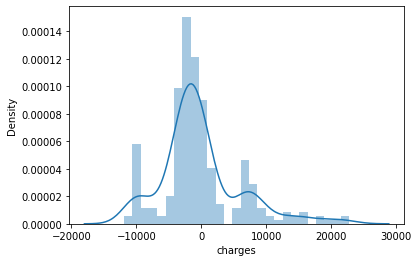

In [18]:
sns.distplot(y_test-elastic_model_predictions)

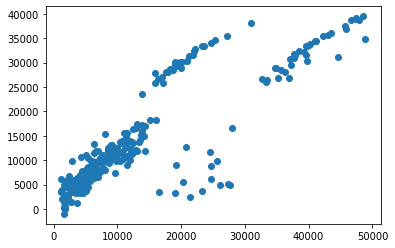

In [19]:
plt.scatter(y_test, elastic_model_predictions)

## Model 3: Random Forest

In [20]:
###Hyperparameters

#Number of tress in random forest
n_estimators=[int(x) for x in np.linspace(start = 100, stop =1200, num=12)]
#Number of features to consider at every split
max_features = ['auto', 'sqrt']
#Max no of levels in tree
max_depth = [int(x) for x in np.linspace(5,30,num=6)]
#Min no of samples required to split a node
min_samples_split = [2,5,10,15,100]
#Min no of samples required at each leaf node
min_samples_leaf = [1,2,5,10]

In [21]:
#Create the random grid
random_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [25]:
rf=RandomForestRegressor()

In [27]:
rf_model = RandomizedSearchCV(estimator =rf, 
                               param_distributions=random_grid, 
                               scoring='neg_mean_squared_error',
                               n_iter =10, 
                               cv =5, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs=1)

In [28]:
rf_model.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   1.4s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   1.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [29]:
rf_predictions=rf_model.predict(X_test)

In [30]:
rf_model_MAE = mean_absolute_error(y_test,rf_predictions)
rf_model_MSE = mean_squared_error(y_test,rf_predictions)
rf_model_RMSE = np.sqrt(rf_model_MSE)
print("Mean absolute error:", rf_model_MAE)
print("Mean squared error:", rf_model_MSE)
print("Root Mean squared error:", rf_model_RMSE)

Mean absolute error: 2437.843951411633
Mean squared error: 21141127.883223213
Root Mean squared error: 4597.948225374358


E:\Users\dheer\AppData\Local\Continuum\anaconda3\envs\medical_insurance\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='charges', ylabel='Density'>

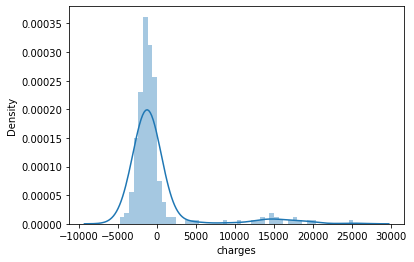

In [31]:
sns.distplot(y_test-rf_predictions)

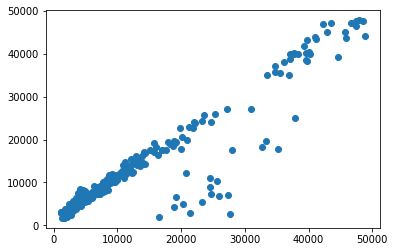

In [32]:
plt.scatter(y_test,rf_predictions)

## Model 3: Neural Network

In [33]:
network = models.Sequential()
network.add(layers.Dense(24, activation='relu', input_shape=(8,)))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(128, activation='relu'))
network.add(layers.Dense(516, activation='relu'))
network.add(layers.Dense(1))
#
# Configure the network with optimizer, loss function and accuracy
#
network.compile(optimizer=optimizers.RMSprop(lr=0.01),
                loss='mse',
                metrics=['mae'])

# Create training and test split
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#
# Fit the network
#
history = network.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=1000,
                    batch_size=20)

E:\Users\dheer\AppData\Local\Continuum\anaconda3\envs\medical_insurance\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/1000
47/47 [==============================] - 4s 15ms/step - loss: 163531248.0000 - mae: 9309.6035 - val_loss: 126133184.0000 - val_mae: 9344.6045
Epoch 2/1000
47/47 [==============================] - 0s 3ms/step - loss: 138244384.0000 - mae: 9008.0645 - val_loss: 125544824.0000 - val_mae: 9745.9531
Epoch 3/1000
47/47 [==============================] - 0s 3ms/step - loss: 132438400.0000 - mae: 8805.8438 - val_loss: 137469792.0000 - val_mae: 6936.2881
Epoch 4/1000
47/47 [==============================] - 0s 3ms/step - loss: 130740544.0000 - mae: 8649.7705 - val_loss: 137432000.0000 - val_mae: 6691.9839
Epoch 5/1000
47/47 [==============================] - 0s 3ms/step - loss: 104566040.0000 - mae: 7676.8770 - val_loss: 98718584.0000 - val_mae: 9493.5840
Epoch 6/1000
47/47 [==============================] - 0s 3ms/step - loss: 83627408.0000 - mae: 6601.5479 - val_loss: 92903936.0000 - val_mae: 5411.5903
Epoch 7/1000
47/47 [==============================] - 0s 3ms/step - loss: 6741

In [34]:
nn_predictions=model.predict(X_test)
nn_MAE = mean_absolute_error(y_test,nn_predictions)
nn_MSE = mean_squared_error(y_test,nn_predictions)
nn_RMSE = np.sqrt(nn_MSE)
print("Mean absolute error:", nn_MAE)
print("Mean squared error:", nn_MSE)
print("Root Mean squared error:", nn_RMSE)

Mean absolute error: 39.356456965189174
Mean squared error: 325045.17809589853
Root Mean squared error: 570.1273349839477


E:\Users\dheer\AppData\Local\Continuum\anaconda3\envs\medical_insurance\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='charges', ylabel='Density'>

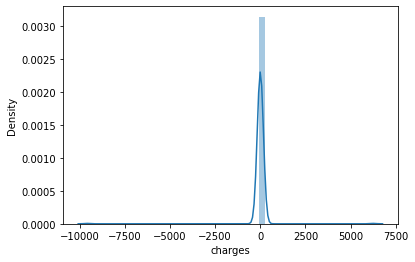

In [35]:
sns.distplot(y_test-nn_predictions)

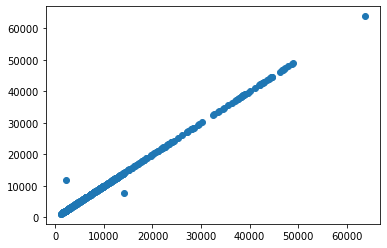

In [36]:
plt.scatter(y_test,nn_predictions)

##

In [38]:
#serialised file for deployment
file = open('neural_network_regression_model.pkl','wb')
pickle.dump(model, file)

In [39]:
final_data.columns

Index(['age', 'bmi', 'children', 'charges', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')